# Coding Notebook 3: Iris Flower Classifier

Today we will be training a neural network on the iris flower dataset

## 1. Set Device and Datatypes For Your Neural Network and Pytorch Tensor

In [ ]:
# first, we'll import tools/modules we need for our pytorch models

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm # nice looking progress bars
import time

In [ ]:
dtype=torch.float
device=torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

## 2. Load the Iris Dataset From Kaggle

https://www.kaggle.com/datasets/uciml/iris

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uciml/iris")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/iris


In [ ]:
import os

In [ ]:
os.listdir(path)

['Iris.csv', 'database.sqlite']

## 3. Load in the File and Do Basic Analysis

Read in downloaded `.csv` "comma seperated values" as a *pandas* `Dataframe`

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv(os.path.join(path, "Iris.csv"))

In [ ]:
data.head(10)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
5,6,5.4,3.9,1.7,0.4,Iris-setosa
6,7,4.6,3.4,1.4,0.3,Iris-setosa
7,8,5.0,3.4,1.5,0.2,Iris-setosa
8,9,4.4,2.9,1.4,0.2,Iris-setosa
9,10,4.9,3.1,1.5,0.1,Iris-setosa


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'SepalLengthCm'}>],
       [<Axes: title={'center': 'SepalWidthCm'}>,
        <Axes: title={'center': 'PetalLengthCm'}>],
       [<Axes: title={'center': 'PetalWidthCm'}>, <Axes: >]], dtype=object)

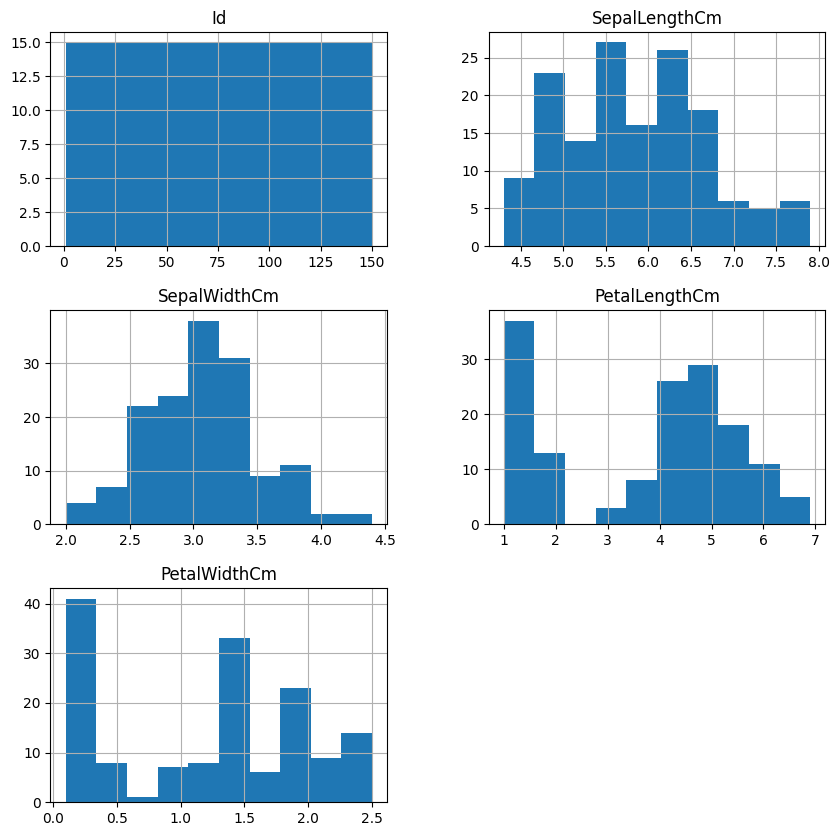

In [ ]:
data.hist(figsize=(10,10))

In [ ]:
data.columns

Index(['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

In [ ]:
labels = data["Species"].unique().tolist()
print(labels)

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']


## 4. Label Encode the `string` labels to `ints` and then split into train, test, and validation datasets

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
data["Species"], label_mapping = pd.factorize(data["Species"])

print(label_mapping)

data["Species"].head()

Index(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype='object')


,Species
0,0
1,0
2,0
3,0
4,0


In [ ]:
X = data.drop(["Id", "Species"], axis=1)
y = data["Species"]

seed = 42


#split train data and temp data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, random_state=seed)

# split temp data into test and val data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=0.5, random_state=seed)

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

90
30
30


In [ ]:
from torch.utils.data import TensorDataset

In [ ]:
dtype = torch.float

# convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=dtype)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long) # Keep as long for CrossEntropyLoss

X_val_tensor = torch.tensor(X_val.values, dtype=dtype)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long) # Keep as long for CrossEntropyLoss

X_test_tensor = torch.tensor(X_test.values, dtype=dtype)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long) # Keep as long for CrossEntropyLoss

# Create Datasets
trainset = TensorDataset(X_train_tensor, y_train_tensor)
valset = TensorDataset(X_val_tensor, y_val_tensor)
testset = TensorDataset(X_test_tensor, y_test_tensor)

# 5. Wrap the dataset in a Dataloader

Dataloaders are an efficient way to iterate and load the dataset, they have additional utility such as batching and shuffling

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# create dataloaders
batch_size= 10

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, drop_last=True)

In [ ]:
print(f"The lengh of the train loader after batching and shuffling is {len(train_loader)}")
print(f"The length of the train loader a * batch size {len(train_loader)*batch_size}\n")
print(f"The length of the trainset: {len(trainset)}")

The lengh of the train loader after batching and shuffling is 9
The length of the train loader a * batch size 90

The length of the trainset: 90


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_name ="Model"):
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  model.train()

  print(f'--- Training {model_name} for {num_epochs} epochs ---')

  for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    acc_val = 0
    total_val = 0
    running_val_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for data, target in pbar:
      data, target = data.to(device), target.to(device)

      # Step 1: zero the gradient
      optimizer.zero_grad()

      # Step 2: forward pass
      output = model(data)

      # Step 3: Calculate the loss
      loss = criterion(output, target)

      # Step 4: Backward pass
      loss.backward()

      # Step 5: Update the weights
      optimizer.step()

      running_loss+= loss.item()
      _, predicted = torch.max(output.data, 1)
      total +=target.size(0)
      correct += (predicted == target).sum().item()

      pbar.set_postfix({'Loss': f'{running_loss/len(train_loader)}', 'Accuracy': f'{100*correct/total}'})

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    model.eval()
    with torch.no_grad():
      for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        val_loss = criterion(output, target)
        running_val_loss += val_loss.item()

        _, predicted = torch.max(output.data, 1)
        total_val += target.size(0)
        acc_val += (predicted == target).sum().item()
    val_losses.append(running_val_loss / len(val_loader))
    val_accuracy = 100 * acc_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Accuracy {val_accuracy}")

  print(f'---Finished training {model_name}---')
  return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
def evaulate_model(model, test_loader):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data) # Forward pass
      _, predicted = torch.max(output, 1)
      total+= target.size(0)
      correct += (predicted == target).sum().item()

  return 100 * correct / total


In [ ]:
features, labels = next(iter(train_loader))
print(features.shape)
print(labels.shape)

torch.Size([10, 4])
torch.Size([10])


In [ ]:
class MLP_Iris(nn.Module):
  def __init__(self):
    super(MLP_Iris, self).__init__()

    # define the layers
    self.fc1  = nn.Linear( 4, 512)
    self.dropout1 = nn.Dropout(0.2)
    self.fc2 = nn.Linear(512, 256)
    self.dropout2 = nn.Dropout(0.2)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 3) # Change output layer to 3 neurons for 3 classes

  def forward(self, x):
    x = x.view(-1, 4)
    x = torch.relu(self.fc1(x))
    x = self.dropout1(x)
    x = torch.relu(self.fc2(x))
    x= self.dropout2(x)
    x = torch.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [ ]:
model_mlp_iris = MLP_Iris().to(device)
optimizer_mlp_iris = optim.Adam(model_mlp_iris.parameters(), lr=.0005)
criterion = nn.CrossEntropyLoss()

# now we use the functions we just created
mlp_losses, mlp_accuracies, val_losses, val_accuracies = train_model(model_mlp_iris, train_loader, val_loader,criterion, optimizer_mlp_iris, num_epochs=20, model_name="MLP on Iris")

mlp_cifar_accuracy= evaulate_model(model_mlp_iris, test_loader)

print(f"Accuracy: {mlp_cifar_accuracy}")

--- Training MLP on Iris for 20 epochs ---


Epoch 1/20: 100%|██████████| 9/9 [00:00<00:00, 148.99it/s, Loss=1.6831501192516751, Accuracy=30.0]


Validation Accuracy 40.0


Epoch 2/20: 100%|██████████| 9/9 [00:00<00:00, 153.45it/s, Loss=0.9475568930308024, Accuracy=58.888888888888886]


Validation Accuracy 100.0


Epoch 3/20: 100%|██████████| 9/9 [00:00<00:00, 151.05it/s, Loss=0.7223034699757894, Accuracy=76.66666666666667]


Validation Accuracy 80.0


Epoch 4/20: 100%|██████████| 9/9 [00:00<00:00, 50.38it/s, Loss=0.6161730123890771, Accuracy=66.66666666666667]


Validation Accuracy 60.0


Epoch 5/20: 100%|██████████| 9/9 [00:00<00:00, 122.32it/s, Loss=0.5098362300131056, Accuracy=71.11111111111111]


Validation Accuracy 96.66666666666667


Epoch 6/20: 100%|██████████| 9/9 [00:00<00:00, 161.32it/s, Loss=0.3849284218417274, Accuracy=93.33333333333333]


Validation Accuracy 96.66666666666667


Epoch 7/20: 100%|██████████| 9/9 [00:00<00:00, 148.56it/s, Loss=0.32717447645134395, Accuracy=90.0]


Validation Accuracy 86.66666666666667


Epoch 8/20: 100%|██████████| 9/9 [00:00<00:00, 153.55it/s, Loss=0.28628194166554344, Accuracy=93.33333333333333]


Validation Accuracy 100.0


Epoch 9/20: 100%|██████████| 9/9 [00:00<00:00, 170.91it/s, Loss=0.23993998600376976, Accuracy=94.44444444444444]


Validation Accuracy 86.66666666666667


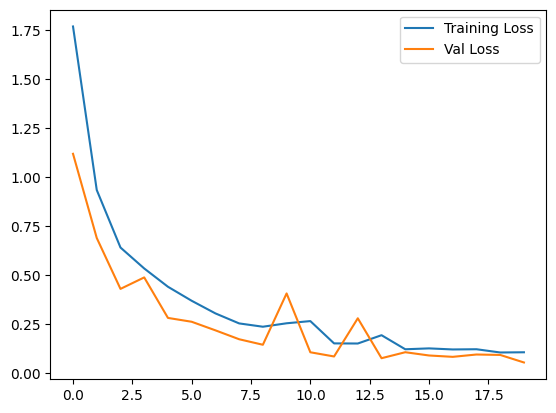

In [ ]:
plt.plot(mlp_losses, label="Training Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()